

# NEWS RECOMMENDER SYSTEM



## Project Outline


---





*   Cleaning of the news articles
*   Tackeling cold-start problem for new users
*   Generation of clickstream data
*   Content based recommendation system
    *   Tf-idf based recommendation system
    *   Topic Based Recommender System
*   Collaborative filtering based recommender system
    * Collaborative filtering based on user similarity score
    * Collaborative filter based on matrix decomposition - SVD method

Importing all the necessary libraries which will be needed in future.


In [0]:
try:
    import numpy as np
    import pandas as pd
    import csv
    import random
    import pickle as pk
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.decomposition import TruncatedSVD
    from sklearn.metrics import silhouette_score
    from sklearn.cluster import KMeans
    import re
    from nltk.stem.snowball import SnowballStemmer
    import nltk
    nltk.download('punkt')
    stemmer = SnowballStemmer("english")
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy" "pandas" "sklearn" "nltk"
    import numpy
    import pandas as pd
    import pickle as pk
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    import re
    from nltk.stem.snowball import SnowballStemmer
    import nltk
    stemmer = SnowballStemmer("english")
    print('Done!')

[nltk_data] Downloading package punkt to /home/prerna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# This part is done to prevent appearance of any future warnings 
# Import warnings filter
from warnings import simplefilter
# Ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# News Corpus Data Cleaning

In this section we will clean all the documents. We will do the following cleaning processes:
* remove punctuations
* remove numbers 
* remove stopwords
* remove single characters
* lemmatization


In [0]:
import string
from gensim import corpora

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')

class Clean_data:

  def __init__(self):
    # Punctuations and stopwords
    self.punctuation = set(string.punctuation)
    self.stoplist = set(stopwords.words('english'))
    # LDA
    self.dictionary = corpora.Dictionary()
    self.lemma = WordNetLemmatizer()

  def remove_punctuation(self, text):
      return ''.join([char for char in text if char not in self.punctuation])
  def remove_numbers(self, text):
      return ''.join([char for char in text if not char.isdigit()])
  def remove_stopwords(self, text):
      return ' '.join([word for word in text.split() if word not in self.stoplist])
  def remove_single_chars(self, text):
      return ' '.join([word for word in text.split() if len(word) > 1])
  def lemmatize(self, text):
      return ' '.join([self.lemma.lemmatize(word) for word in text.split()])
  def clean_text(self, text):
      text = text.replace('\n', '')
      text = self.remove_punctuation(text)
      text = self.remove_numbers(text)
      text = self.remove_stopwords(text)
      text = self.remove_single_chars(text)
      text = self.lemmatize(text)
      return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
news_articles = pd.read_csv('corpus_final.csv')
article_ids = list(news_articles['Article_id'])


In [0]:
articles = news_articles['Article content'].tolist()
news_articles.tail()

,Article_id,Date,Author,Topic,Headline,Article content
10242,10243,2020-05-03 00:00:00,['Daniel Marland'],sports,Real Madrid Want To Sign Erling Haaland In 202...,Real Madrid are planning an audacious swoop fo...
10243,10244,NaN,['Jack Kenmare'],sports,The 14 Players On Manchester United's Transfer...,Manchester United 'summer shortlist' has emerg...
10244,10245,NaN,['Daniel Marland'],sports,Newcastle Fans Are Hoping To Sign Harry Kane A...,Newcastle United fans are hoping the club make...
10245,10246,NaN,['Ryan Sidle'],sports,Manchester United Eye Potential Alternative To...,Manchester United could move for Ferran Torres...
10246,10247,NaN,['Ryan Sidle'],sports,Mike Ashley In 'Advanced' Talks To Sell Newcas...,Mike Ashley is in 'advanced talks' to sell New...


In [0]:
cleaned_articles=[]
for i in range(len(articles)):
  clean = Clean_data()
  clean.remove_punctuation(articles[i])
  clean.remove_numbers(articles[i])
  clean.remove_stopwords(articles[i])
  clean.remove_single_chars(articles[i])
  clean.lemmatize(articles[i])
  c=clean.clean_text(articles[i])
  cleaned_articles.append(c)
print(cleaned_articles[:10])

['Dutta accused Patekar intimidating harassing filming song set unreleased film Horn Ok Pleasss Dutta first made allegation film’s production reiterated September return India United States America Patekar called allegation motivated malicious Dutta filed police complaint actor Apart successful career Telugu Tamil cinema Daggubati appeared several Hindi film including Dum Maaro Dum Baby TeluguHindi biligual The Ghazi Attack', 'As expected slider phone Huawei Honor Magic launched event Beijing yesterday lot teased phone prior launch biggest takeaway company’s latest nm HiSilicon Kirin SoC This powerful chip yet designed Chinese company moreover nm processing make second chip available market Apple’s Bionic The smartphone pack numerous eyecatching feature It sport triple rear camera setup fast charging tech dubbed Magic Charge inch AMOLED full screen display indisplay fingerprint sensor face unlock much Moreover there’s front slider house selfie sensor mean smartphone get notchless full 

# The Cold Start Problem


*  We plan to solve it by giving diverse set of articles to users.
*  we will first generate TF-IDF matrix of entire corpus
*  Then, used SVD to reduce dimentionality of the tfidf matrix
*  Silhouette score is calculated to find the optimal number of clusters in k means clustering
*  Then we will recommend articles from these clusters

**1. Generate tfidf matrix model for entire corpus**

In [0]:
tfidf_matrix = TfidfVectorizer(stop_words='english', min_df=2)
article_tfidf_matrix = tfidf_matrix.fit_transform(cleaned_articles)
terms = tfidf_matrix.get_feature_names()
article_tfidf_matrix #tfidf vector of an article

<10247x55814 sparse matrix of type '<class 'numpy.float64'>'
	with 1794271 stored elements in Compressed Sparse Row format>

**2. Using SVD to reduce dimentionality of the tfidf matrix**





In [0]:
svd = TruncatedSVD(n_components=100,random_state=9)
vector_matrix = svd.fit_transform(article_tfidf_matrix)

**3. Evaluation method - Silhouette score to find the optimal number of clusters in k means clustering**

In [0]:
#The following code can be skipped while running the notebook since it is a bit time intensive due to the multiple runs of kmeans.
#we find that the best silhouette score is obtained when the number of clusters for kmeans=9.
#uncomment to run this cell
'''
range_n_clusters = list (range(2,30))
x=[]
y=[]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters,init='k-means++',max_iter=300,n_init=10,random_state=9)
    preds = clusterer.fit_predict(vector_matrix)
    centers = clusterer.cluster_centers_

    score = silhouette_score(vector_matrix, preds)
    #print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    x.append(n_clusters)
    y.append(score)
n_clusters=x[y.index(max(y))]
print(n_clusters) #to print cluster number with max silhouette score

plt.plot(x, y) 
plt.xlabel('number of clusters (k)')  
plt.ylabel('Silhouette score') 
plt.title('Silhouette score for Kmeans clustering') 
plt.savefig('k-means_silhouetter_score.png')
plt.show() 
'''  and None

**4. Fitting K-Means to the dataset**

In [0]:
n_clusters=9
kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(vector_matrix)
kmeans_fit=kmeans.fit(vector_matrix)

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8')]

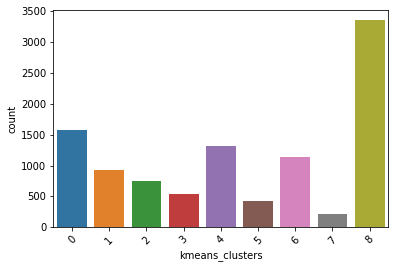

In [0]:
kmeans_df = pd.DataFrame()
kmeans_df['kmeans_clusters'] = kmeans.fit(vector_matrix).labels_
#label=kmeans.fit(vec_matrix_pca).labels_
ax = sns.countplot(x= 'kmeans_clusters', data=kmeans_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

**5. Recommend diverse articles from the clusters**

In [0]:
def recommend_diverse_articles():
  l=[]
  recommend=[]
  cluster_label=np.array(kmeans_fit.labels_)
  for i in range(n_clusters):
    b=np.where(cluster_label==i)
    c=random.choice(b[0])
    recommend.append(c)
  for i in range(10-n_clusters):
    f=random.choice(range(1,len(cleaned_articles)))
    if f not in recommend:
      recommend.append(f)
  #print(recommend)
  #for i in range(len(recommend)):
    #print('Article %d : ' % (i+1) , news_articles['Headline'][recommend[i]])
  return recommend
recommend_diverse_articles()

[1657, 3009, 1245, 1026, 6632, 8826, 1620, 3152, 7987, 702]

# Clickstream data

* We generate three types of users as per our assumptions.
* We serve diverse articles to all users in session #1
* from next sessions it serves random articles to new users and personalized articles to repeat users.
* Clickstream data is stored in a csv file for further use.



In [0]:
class Click_data:
    
    def __init__(self,article_ids,num_of_users):
        self.bounce_users_ids=[]
        self.one_time_users_ids=[]
        self.regular_users_ids=[]
        self.user_ids = []
        self.user_articles = {}
        self.clickstream = {}
        self.article_ids = article_ids
        self.num_of_users = num_of_users
        self.fields = ['user id','session id','article id' ,'click','ratings','time spent', 'user type']
        csvfile = open('clickstream.csv', 'w')
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(self.fields)
        csvfile.close()

    def gen_new_users(self):
        self.bounce_users_ids=[]
        self.one_time_users_ids=[]
        #self.user_articles = {}
        #assign randomly ids to various users types
        for i in range(int(self.num_of_users*0.25)):
            r = random.randint(1000000,9999999)

            while r in self.user_ids:                               
                r = random.randint(1000000,9999999) 
                
            self.user_ids.append(r)          #to keep track of all the users
            self.bounce_users_ids.append(r)   #to keep track of bounce users
            #self.user_articles[r] = random.choices(self.article_ids,k=10) #random 10 articles assigned for now
            self.user_articles[r] = recommend_diverse_articles()
            
        for i in range(int(self.num_of_users*0.50)):
            r = random.randint(1000000,9999999)
            while r in self.user_ids:
                r = random.randint(1000000,9999999)
            self.user_ids.append(r)          #to keep track of all the users
            self.one_time_users_ids.append(r) #one time users
            
            # diverse articles recommender - kmeans : add over here
            #self.user_articles[r] = random.choices(self.article_ids,k=10)
            self.user_articles[r] = recommend_diverse_articles()
    
    def gen_regular_users(self):
        #These are regular users we dont have to generate them in every iteration of new session
        for i in range(int(self.num_of_users*0.25)):
            r = random.randint(1000000,9999999)
            while r in self.user_ids:
                r = random.randint(1000000,9999999)
            self.user_ids.append(r)          #to keep track of all the users
            self.regular_users_ids.append(r) #repeat users
            #self.user_articles[r] = random.choices(self.article_ids,k=10)
            self.user_articles[r] = recommend_diverse_articles()

    def regular_users(self):
      # add recommender system in this code.... 
      for r in self.regular_users_ids:
        #self.user_articles[r] = random.choices(self.article_ids,k=10)
        self.user_articles[r] = tf.recommend_articles(r)[0]


    # a function to generate clickstream 
    def gen_clickstream(self,session_id):
      
      if(session_id == 1):
        self.gen_new_users()
        self.gen_regular_users()  #need to generate only once

      else:
        self.gen_new_users()
        self.regular_users()

      self.clickstream = {}
      timespend_type1 = np.random.normal(0,0,int(self.num_of_users*0.25))               # no clicks or reads

      mean2 = [100,3]
      cov2 = [[600.  ,21.35714286],
        [ 21.35714286 ,0.77267857]]

      timespend_type2 = [np.random.multivariate_normal(mean2, cov2,random.choices([1,2,3],[0.7,0.2,0.1])) for i in range(int(self.num_of_users*0.50))]

      mean3 = [180,3]
      cov3 =  [[1.22142857e+03, 2.28928571e+01],
              [2.28928571e+01, 4.41250000e-01]]
      timespend_type3 = [np.random.multivariate_normal(mean3, cov3,random.choices([1,2,3,4],[0.4,0.3,0.2,0.1])) for i in range(int(self.num_of_users*0.25))]


      for i in range(len(self.bounce_users_ids)):
          self.clickstream[self.bounce_users_ids[i]] = [[session_id,random.choice(self.user_articles[self.bounce_users_ids[i]]),'no','0',timespend_type1[i],'bounce']] 

      for i in range(len(self.one_time_users_ids)):
          temp = []
          for j in timespend_type2[i]:
              temp.append([session_id,random.choice(self.user_articles[self.one_time_users_ids[i]]),'yes',round(j[1]),round(j[0]),'one time'])
          self.clickstream[self.one_time_users_ids[i]] = temp

      for i in range(len(self.regular_users_ids)):
          temp = []
          for j in timespend_type3[i]:
              temp.append([session_id,random.choice(self.user_articles[self.regular_users_ids[i]]),'yes',round(j[1]),round(j[0]),'regular'])
          self.clickstream[self.regular_users_ids[i]] = temp

      with open('clickstream.csv', 'a') as csvfile: 
        csvwriter = csv.writer(csvfile)
        for i in self.clickstream.keys():
            for j in self.clickstream[i]:
                # writing the data rows 
                j.insert(0,i)
                csvwriter.writerow(j)
        clickstream_data = pd.read_csv('clickstream.csv')
      return clickstream_data


In [0]:
f=Click_data(article_ids,1000) #give article ids and number of users
clickstream_data=f.gen_clickstream(1) #1 represent session id

## Visualization of user clickstream after session 1

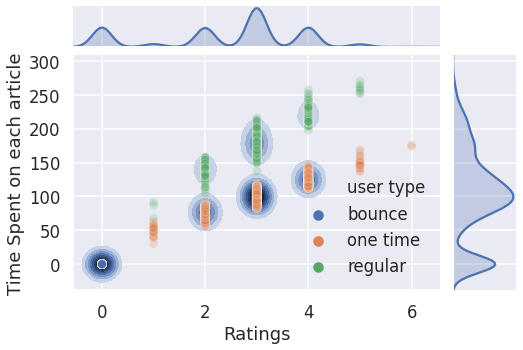

In [0]:
sns.set(context='talk')

#add a column for the type of user
ids = list(clickstream_data['user id'])

#plot and save the multi-variate distribution
g = sns.jointplot(x="ratings", y="time spent", data=clickstream_data, kind="kde")
g.plot_joint(sns.scatterplot, data=clickstream_data, hue = 'user type',alpha=0.2)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("Ratings", "Time Spent on each article")
g.fig.set_figwidth(8)
g.fig.set_figheight(5)
plt.legend(loc='lower right',framealpha=0)
plt.show()

# Tf-idf based recommendation system

*  Convert the cleaned articles into tf-idf matrix

*  convert the user into tf-idf vector based on interacted articles

*  recommmend articles based on similarities

Class for TFIDF recommender

In [0]:
# Read clickstream data
user_data = pd.read_csv('clickstream.csv')

class TFIDF_recommender():
    MODEL_NAME = 'TFIDF'

    def model_name(self):
        return MODEL_NAME

    def __init__(self,article_tfidf_matrix,user_data,news_articles,cleaned_articles):
        self.article_tfidf_matrix = article_tfidf_matrix
        self.user_data = user_data.set_index('user id')
        self.news_articles = news_articles
        self.cleaned_articles = np.array(cleaned_articles)
        self.number_of_recommendations = 10
      
    def interacted_ids(self,userid):      
      article_ids = self.user_data.loc[userid]['article id']
      ratings_given = self.user_data.loc[userid]['ratings']
      if isinstance(article_ids, (np.int64)):
        article_ids = [article_ids]
        ratings_given = [ratings_given]
      else:
        article_ids = list(article_ids)
        ratings_given = list(ratings_given)
      return article_ids, ratings_given
    
    def news_articles_id(self,articles_read_ids):
      article_read_ind = []
      for id in articles_read_ids:
        article_read_ind.append(np.where(self.news_articles['Article_id'] == id)[0][0])
      return article_read_ind

    def recommend_articles(self,userid):
        articles_read_ids = self.interacted_ids(userid)[0]
        #print(articles_read_ids)
        articles_read_ind = self.news_articles_id(articles_read_ids)
        articles_read = self.cleaned_articles[articles_read_ind]
        user_articles = ' '.join(article for article in articles_read)  
        user_article_tfidf_vector = tfidf_matrix.transform([user_articles])
        articles_similarity_score=cosine_similarity(self.article_tfidf_matrix, user_article_tfidf_vector)
        recommended_articles_ind = articles_similarity_score.flatten().argsort()[::-1]
        recommended_articles_id = np.array(news_articles['Article_id'])[recommended_articles_ind]
        #print(recommended_articles_id[:self.number_of_recommendations])
        return recommended_articles_id[:self.number_of_recommendations],news_articles['Headline'][recommended_articles_ind][:self.number_of_recommendations ]


In [0]:
tf = TFIDF_recommender(article_tfidf_matrix,user_data,news_articles,cleaned_articles)

In [0]:
uid = random.choice(list(user_data['user id']))
tf.recommend_articles(uid)


(array([1627,  970, 1679,  715, 1500, 1401, 1200, 4222, 5302, 4694]),
 1626    Pune ATP Challenger: Prajnesh looks for consec...
 969     Bengaluru Open preview: Prajnesh and Nagal lea...
 1678    The next step: Prajnesh Gunneswaran has eyes o...
 714     Indian tennis: Saketh Myneni gets final wildca...
 1499    Tennis: Maharashtra’s Arjun Kadhe and Aryan Go...
 1400    Bengaluru Open tennis: Myneni knocks out defen...
 1199    Told Marco Trungelliti he owes me €10,000, jok...
 4221    India needs more ATP Challengers like Bengalur...
 5301    Indian tennis: Yuki Bhambri and Ramkumar Raman...
 4693    Indian tennis: Gunneswaran enters Ningbo Chall...
 Name: Headline, dtype: object)

# Evaluation based on nDCG score

In [0]:
# run this block before using evaluator
#input userid and get the articles ids and ratings he has given
def interacted_ids(userid,user_data):      
  article_ids = user_data.loc[userid]['article id']
  ratings_given = user_data.loc[userid]['ratings']
  if isinstance(article_ids, (np.int64)):
    article_ids = [article_ids]
    ratings_given = [ratings_given]
  else:
    article_ids = list(article_ids)
    ratings_given = list(ratings_given)
  return article_ids, ratings_given


In [0]:
class Evaluator():
    def __init__(self,user_data,news_articles):
        self.user_data = user_data.set_index('user id')
        self.news_articles = news_articles

    def evaluate_model_for_user(self,model,userid):

        articles_read_rate = interacted_ids(userid,self.user_data)
        #articles_read_rate = np.array(articles_read_rate)
        articles_interaction = {}
        if len(articles_read_rate[0])>=2:                #including users with atleast 2 ratings
            for i,j in zip(articles_read_rate[0],articles_read_rate[1]):
                articles_interaction[int(i)] = int(j)
            reco_art = model.recommend_articles(userid)
            relevance = []
            for i in list(reco_art[0]):
                if i in articles_interaction.keys():
                    relevance.append(articles_interaction[i])
                else:
                    relevance.append(0)
            #print(relevance)
            ndcg_score = self.ndcg_at_k(relevance,10)
            return ndcg_score
        else:
            return 0
       
    
    
        
    def dcg_at_k(self,r, k, method=0):
        r = np.asfarray(r)[:k]
        #print(r)
        if r.size:
            if method == 0:
                return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
            elif method == 1:
                return np.sum(r / np.log2(np.arange(2, r.size + 2)))
            else:
                raise ValueError('method must be 0 or 1.')
        return 0.

    def ndcg_at_k(self,r, k, method=1):
        dcg_max = self.dcg_at_k(sorted(r, reverse=True), k, method)
        #print('dcg_max = ', dcg_max)
        if not dcg_max:
            return 0.
        #print('dcg_at_k = ', self.dcg_at_k(r, k, method))
        return self.dcg_at_k(r, k, method) / dcg_max

    def evaluate_model(self, model):
        user_data_short = self.user_data[self.user_data['user type'] == 'regular']
        n = 0
        score = 0
        for i in list(user_data_short.index):
          score += self.evaluate_model_for_user(model,i)
          n += 1
        return print('Score of the model is',score/n)


In [0]:
E = Evaluator(user_data,news_articles)

In [0]:
E.evaluate_model(tf)

Score of the model is 0.7850136261536628


# Topic Based Recommender System
*   Create term dictionary of the corpus
*   remove words which are on both extreme 
*   create document term matrix
*   run the lda model
*   visualise the corpus acc to words-topics distribution
*  create article topic distribution
*  create user matrix in terms of read article topic distribution
*  recommend articles according to cosine similarities 

In [0]:
tokens = [[i for i in doc.lower().split()] for doc in cleaned_articles]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokens)

# Remove words that appear less than 5 times and that are in more than in 80% documents
dictionary.filter_extremes(no_below=5, no_above=0.8)

In [0]:
import gensim
from gensim import corpora, models
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokens]

In [0]:
RANDOM_STATE=1
NUM_PASSES = 5
NUM_TOPICS = 100
NUM_WORDS=10

# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=NUM_TOPICS, id2word = dictionary, passes=NUM_PASSES, random_state=RANDOM_STATE)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [0]:
topic_words = ldamodel.show_topics(num_topics=NUM_TOPICS, num_words=NUM_WORDS)  # narray of Shape: n_topics*vocab
topic_words

[(0,
  '0.013*"court" + 0.011*"law" + 0.010*"government" + 0.010*"temple" + 0.009*"supreme" + 0.009*"state" + 0.008*"right" + 0.007*"act" + 0.007*"india" + 0.007*"said"'),
 (1,
  '0.036*"saudi" + 0.029*"us" + 0.027*"united" + 0.024*"president" + 0.020*"states" + 0.016*"arabia" + 0.016*"war" + 0.015*"military" + 0.013*"trump" + 0.013*"country"'),
 (2,
  '0.108*"pennsylvania" + 0.056*"blockbuster" + 0.042*"mendes" + 0.036*"doubting" + 0.035*"selfish" + 0.023*"turbulent" + 0.020*"squirrel" + 0.020*"dangal" + 0.019*"lively" + 0.019*"elliott"'),
 (3,
  '0.019*"said" + 0.014*"think" + 0.012*"team" + 0.012*"good" + 0.012*"get" + 0.011*"going" + 0.011*"like" + 0.010*"game" + 0.010*"lot" + 0.010*"thing"'),
 (4,
  '0.060*"was" + 0.058*"now" + 0.037*"twitch" + 0.021*"dad" + 0.020*"hell" + 0.017*"dwayne" + 0.015*"tom" + 0.012*"auction" + 0.011*"london" + 0.011*"tradeoff"'),
 (5,
  '0.032*"goal" + 0.017*"minute" + 0.014*"win" + 0.014*"first" + 0.009*"second" + 0.009*"penalty" + 0.008*"half" + 0.008

In [0]:
!pip install pyldavis

In [0]:
# Visualize the topics
import pyLDAvis.gensim
import pickle 
import pyLDAvis
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
#pyLDAvis.save_html(LDAvis_prepared, 'output_filename.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
69     0.190528 -0.018023       1        1  8.106496
71     0.236216  0.094293       2        1  6.388819
44     0.232133  0.033223       3        1  5.045898
3      0.249272  0.124280       4        1  4.699872
26     0.171858 -0.025365       5        1  3.414193
...         ...       ...     ...      ...       ...
65    -0.232770  0.023316      96        1  0.061660
62    -0.226388  0.023813      97        1  0.060562
9     -0.232621  0.019739      98        1  0.048135
34    -0.241814  0.023001      99        1  0.036346
2     -0.242030  0.021819     100        1  0.022258

[100 rows x 5 columns], topic_info=             Term          Freq         Total  Category  logprob  loglift
284          said  18119.000000  18119.000000   Default  30.0000  30.0000
1314        woman   4852.000000   4852.000000   Default  29.0000  29.0000
638          game   6501.000000   6501.000000   Default  28.0000  28.0000
70        company   4729.000000   4729.000000   Default  27.0000  27.0000
1299   university   2990.000000   2990.000000   Default  26.0000  26.0000
...           ...           ...           ...       ...      ...      ...
19143  expensive”      1.445494      2.623756  Topic100  -6.1641   7.8141
12976    quickly”      5.245070     10.041832  Topic100  -4.8752   7.7608
6411    turbulent     16.138580     34.717735  Topic100  -3.7513   7.6442
22756    powering      3.776934     13.635807  Topic100  -5.2036   7.1264
17282   synagogue      4.147579     50.178444  Topic100  -5.1100   5.9172

[6231 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
14099      9  0.988006  aadhaar
14099     48  0.009321  aadhaar
7155      10  0.072935    aaron
7155      19  0.125979    aaron
7155      32  0.066305    aaron
...      ...       ...      ...
1712      26  0.011602     “you
1712      30  0.027070     “you
1712      33  0.015469     “you
12980    100  0.773692   “you’d
19845     74  0.917774       “”

[31300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[70, 72, 45, 4, 27, 100, 30, 16, 1, 24, 20, 99, 75, 65, 23, 48, 57, 21, 59, 73, 6, 84, 74, 26, 12, 91, 50, 15, 31, 92, 93, 8, 17, 44, 33, 79, 38, 77, 11, 67, 49, 90, 69, 40, 88, 94, 34, 83, 2, 25, 95, 86, 52, 78, 64, 56, 96, 13, 71, 60, 28, 47, 61, 89, 98, 58, 7, 85, 87, 41, 29, 62, 51, 53, 68, 82, 97, 5, 80, 9, 39, 14, 32, 42, 19, 54, 37, 81, 43, 22, 18, 55, 76, 46, 36, 66, 63, 10, 35, 3])

In [0]:
#to prepare article topic distribution list

fields = ['article_id','topic_id','topic_weight']
csvfile = open('article_topic_distribution.csv', 'w')
csvwriter = csv.writer(csvfile)
csvwriter.writerow(fields)
csvfile.close()

with open('article_topic_distribution.csv', 'a') as csvfile:
    csvwriter = csv.writer(csvfile) 
    for i in range(len(doc_term_matrix)):
        temp = ldamodel.get_document_topics(doc_term_matrix[i])
        for j in temp:
            csvwriter.writerow((i,j[0],j[1]))

In [0]:
article_topic_distribution = pd.read_csv('article_topic_distribution.csv')
article_topic_distribution.tail()

,article_id,topic_id,topic_weight
123157,10246,40,0.012901
123158,10246,44,0.051373
123159,10246,68,0.321468
123160,10246,82,0.010778
123161,10246,83,0.027836


In [0]:
article_topic_pivot = article_topic_distribution.pivot(index='article_id', columns='topic_id', values='topic_weight')

article_topic_pivot.fillna(value=0, inplace=True)  #Fill NaN with 0

articles_topic_matrix = article_topic_pivot.values #Get the values in dataframe as matrix
articles_topic_matrix.shape

In [0]:
article_topic_pivot.head()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
article_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.085512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.154827,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.060237,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.042081,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.717822,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.016802,0.0,0.0,0.0,0.04043,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.011318,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.088244,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.043842,0.000000,0.0,0.000000,0.0,0.000000,0.022237,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.034527,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.122224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.540373,0.000000,0.000000,0.0,0.132371,0.0,0.000000,0.0,0.063229,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.307632,0.0,0.024836,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.013378,0.052250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049704,0.0,0.0,0.0,0.0,0.0,0.000000,0.036328,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.037097,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298386,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.025048,0.0,0.0,0.000000,0.000000,0.084922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.025571,0.000000,0.452011,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [0]:
class Topic_recommender():
    
    MODEL_NAME = 'Topic based recommender'

    def model_name(self):
        return MODEL_NAME

    def __init__(self,user_data,news_articles,articles_topic_matrix):
        self.user_data = user_data.set_index('user id')
        self.news_articles = news_articles
        self.articles_topic_matrix = articles_topic_matrix

    def recommend_articles(self,userid):
        ARTICLES_READ = interacted_ids(userid,self.user_data)[0]
        #Select user in terms of read article topic distribution
        row_idx = np.array(ARTICLES_READ)
        read_articles_topic_matrix=self.articles_topic_matrix[row_idx[:, None]]
        #Calculate the average of read articles topic vector 
        user_vector = np.mean(read_articles_topic_matrix, axis=0)
        articles_similarity_score=cosine_similarity(self.articles_topic_matrix, user_vector)
        recommended_articles_id = articles_similarity_score.flatten().argsort()[::-1]
        #Remove read articles from recommendations
        final_recommended_articles_id = [article_id for article_id in recommended_articles_id if article_id not in ARTICLES_READ ][:10]
        
        return final_recommended_articles_id,news_articles['Headline'][final_recommended_articles_id]
        #return recommended_articles_id,news_articles['Headline'][recommended_articles_id]
    

In [0]:
TR = Topic_recommender(user_data,news_articles,articles_topic_matrix)

In [0]:
uid = random.choice(list(user_data['user id']))
TR.recommend_articles(uid)


([10186, 10204, 10003, 9532, 9649, 9890, 9996, 10063, 9734, 10167],
 10186    WWE NXT Women's Champion Charlotte Flair: "I D...
 10204    Conor McGregor Makes 'Shivers' Admission About...
 10003    Koneru Humpy wins World Rapid Chess Championships
 9532     Holyfield, Foreman and 15 other former champs:...
 9649     Call of Duty League coaches poll: Is Dallas th...
 9890     George Kittle, Daniel Cormier, WWE stars react...
 9996     Kramnik, Gelfand and all the right moves at Ch...
 10063    QUIZ: Can You Name The Former Premier League P...
 9734     Horses for courses: Fouaad's silver adds to fa...
 10167    Jose Mourinho Reveals The Only Loss That Cause...
 Name: Headline, dtype: object)

collaborative filtering need for session data to give good results...

In [0]:
#generating clickstream data for next session using tfidf recommender
for i in range(2,9):
  f.gen_clickstream(i) #sessions 2 to 8


# Collaborative filtering based recommender system

**Collaborative filtering based on user similarity score**

 *  created a users vs document rating matrix
 *  use it to find the cosine similarity between different users
 *  We estimate the unknown rating by taking weighted average and then recommend 10 articles based on the estimated ratings.


In [0]:
user_data = pd.read_csv('clickstream.csv')
class Collaborative_Cosine_Similarity_Recommender():
    MODEL_NAME = 'CCSR'
    def __init__(self,article_tfidf_matrix,user_data,news_articles,cleaned_articles):
        self.article_tfidf_matrix = article_tfidf_matrix
        self.user_id = list(set(user_data['user id']))
        self.user_data = user_data.set_index('user id')
        self.news_articles = news_articles
        self.cleaned_articles = np.array(cleaned_articles)
        self.number_of_recommendations = 10
        self.article_ids = list(set(self.news_articles['Article_id']))
        self.rat_matrix = np.zeros((len(self.user_id),len(article_ids)))      
        self.k_nearest_users = 10
        
    def interacted_ids(self,userid):      
      article_ids = self.user_data.loc[userid]['article id']
      ratings_given = self.user_data.loc[userid]['ratings']
      if isinstance(article_ids, (np.int64)):
        article_ids = [article_ids]
        ratings_given = [ratings_given]
      else:
        article_ids = list(article_ids)
        ratings_given = list(ratings_given)
      return article_ids, ratings_given
    
    def news_articles_id(self,articles_read_ids):
      article_read_ind = []
      for id in articles_read_ids:
        article_read_ind.append(np.where(self.news_articles['Article_id'] == id)[0][0])
      return article_read_ind

    def rating_mat_update(self):
      for ind in range(len(self.user_id)):
        articles_read_ids, ratings = self.interacted_ids(user_id[ind])
        articles_read_ind = self.news_articles_id(articles_read_ids)
        self.rat_matrix[ind][articles_read_ind] = ratings

    def recommend_articles(self,userid):
      uid = np.where(userid == np.array(self.user_id))[0][0]
      self.rating_mat_update()
      user_similarity_score = cosine_similarity(self.rat_matrix, self.rat_matrix[uid].reshape(1,self.rat_matrix.shape[-1])).flatten()
      similar_user_ind = np.argsort(user_similarity_score)[::-1][1:self.number_of_recommendations+1]

      for ir in range(self.rat_matrix.shape[-1]):
        tot = 0
        num = 0
        for ik in range(self.k_nearest_users):
          num+=user_similarity_score[similar_user_ind[ik]]*self.rat_matrix[similar_user_ind[ik]][ir]
          tot+=user_similarity_score[similar_user_ind[ik]]
        if(tot != 0):
          self.rat_matrix[uid][ir] = num/tot
      recommended_articles_ind = np.argsort(self.rat_matrix[uid])[::-1]
      recommended_articles_id = np.array(news_articles['Article_id'])[recommended_articles_ind]
      final_recommended_articles_ind = [np.where(article_id == news_articles['Article_id'])[0][0] for article_id in recommended_articles_id][:self.number_of_recommendations]
      return recommended_articles_id[:self.number_of_recommendations],news_articles['Headline'][recommended_articles_ind][:self.number_of_recommendations]


In [0]:
cssr = Collaborative_Cosine_Similarity_Recommender(article_tfidf_matrix,user_data,news_articles,cleaned_articles)


In [0]:
user_id = list(set(user_data['user id']))
userid = random.choice(user_id)
#uid = np.where(userid == user_id)[0][0]
print(userid)
cssr = Collaborative_Cosine_Similarity_Recommender(article_tfidf_matrix,user_data,news_articles,cleaned_articles)
cssr.recommend_articles(userid)


6725668


(array([ 6252, 10247,  3413,  3420,  3419,  3418,  3417,  3416,  3415,
         3414]), 6251                  Conservatives’ self-delusion on race
 10246    Mike Ashley In 'Advanced' Talks To Sell Newcas...
 3412     Malaysia: Former PM Najib Razak’s wife charged...
 3419     UK, Australia accuse Russian military intellig...
 3418     India hockey legend Balbir Singh admitted to I...
 3417     Messi means business, Tottenham squad exposed:...
 3416     Bullet train project: Japanese agency ready to...
 3415     CBSE class 9, 11 registration now open, apply ...
 3414     Youth Olympic Games: Where are India’s previou...
 3413     US: Donald Trump to nominate Indian-American e...
 Name: Headline, dtype: object)

**Collaborative filter based on matrix decomposition - SVD method**

 * We created the user vs article rating matrix
 * reduced its dimensions using Singular Value Decomposition method
 * The user vs article matrix was then re-calculated to recommend articles based on the estimated ratings.


In [0]:
from scipy.sparse.linalg import svds
user_data = pd.read_csv('clickstream.csv')
class Collaborative_Matrix_Fact_Recommender():
    MODEL_NAME = 'CMFR'
    def __init__(self,article_tfidf_matrix,user_data,news_articles,cleaned_articles):
        self.article_tfidf_matrix = article_tfidf_matrix
        self.user_id = list(set(user_data['user id']))
        self.user_data = user_data.set_index('user id')
        self.news_articles = news_articles
        self.cleaned_articles = np.array(cleaned_articles)
        self.number_of_recommendations = 10
        self.article_ids = list(set(self.news_articles['Article_id']))
        self.rat_matrix = np.zeros((len(self.user_id),len(article_ids)))      
        self.k_nearest_users = 10
    def interacted_ids(self,userid):      
      article_ids = self.user_data.loc[userid]['article id']
      ratings_given = self.user_data.loc[userid]['ratings']
      if isinstance(article_ids, (np.int64)):
        article_ids = [article_ids]
        ratings_given = [ratings_given]
      else:
        article_ids = list(article_ids)
        ratings_given = list(ratings_given)
      return article_ids, ratings_given
    
    def news_articles_id(self,articles_read_ids):
      article_read_ind = []
      for id in articles_read_ids:
        article_read_ind.append(np.where(self.news_articles['Article_id'] == id)[0][0])
      return article_read_ind

    def rating_mat_update(self):
      for ind in range(len(self.user_id)):
        articles_read_ids, ratings = self.interacted_ids(user_id[ind])
        articles_read_ind = self.news_articles_id(articles_read_ids)
        self.rat_matrix[ind][articles_read_ind] = ratings

    def recommend_articles(self,userid):
      uid = np.where(userid == np.array(self.user_id))[0][0]
      self.rating_mat_update()
      #The number of factors to factor the user-item matrix.
      mumber_of_factors_mf = 10

      #Performs matrix factorization of the original user item matrix
      U, sigma, Vt = svds(self.rat_matrix, k = mumber_of_factors_mf)

      sigma = np.diag(sigma)
      all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
      #all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())
      all_user_predicted_ratings_norm = all_user_predicted_ratings
      recommended_articles_ind = np.argsort(all_user_predicted_ratings_norm[uid])[::-1]
      recommended_articles_id = np.array(news_articles['Article_id'])[recommended_articles_ind]
      final_recommended_articles_ind = [np.where(article_id == news_articles['Article_id'])[0][0] for article_id in recommended_articles_id][:self.number_of_recommendations]
      return recommended_articles_id[:self.number_of_recommendations],news_articles['Headline'][recommended_articles_ind][:self.number_of_recommendations]


In [0]:
user_id = list(set(user_data['user id']))
userid = random.choice(user_id)
print(userid)
cmfr = Collaborative_Matrix_Fact_Recommender(article_tfidf_matrix,user_data,news_articles,cleaned_articles)
cmfr.recommend_articles(userid)




8156687


(array([3616, 8719, 2787,  327, 9022, 9433, 5158, 5039, 3449, 6852]),
 3615    Gujarat: 150 arrested for attacking migrants f...
 8718    Blackmagic Pocket Cinema Camera 6K review: DP ...
 2786    Centre names eight-member search committee to ...
 326     Chhattisgarh: Woman whose infant fell into hos...
 9021    Dell XPS 13 (late 2019) review: the one with s...
 9432    Pro Kabaddi League 2019 - PKL Season 7 News, S...
 5157    Under-fire Real Madrid coach Lopetegui promise...
 5038    Chhattisgarh Police detain three journalists r...
 3448    More focus, less unforced errors: What Naomi O...
 6851    Mary, Queen of Scots, Loses Her Head and the A...
 Name: Headline, dtype: object)